# Setup enviorment

In [ ]:
%cd ..

In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor, preprocess_dataset_to_time_series

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings/ResNet50V2_Per_Band/224_band12.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T=0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

## 2. Preprocessing

### Train Test split

In [5]:
train_df = dengue_df[:int(len(dengue_df)*(train_percentage/100))]
Municipalities_train = Municipalities[:int(len(dengue_df)*(train_percentage/100))]
test_df = dengue_df[int(len(dengue_df)*(train_percentage/100)):]
Municipalities_test = Municipalities[int(len(dengue_df)*(train_percentage/100)):]
#test_df

### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities_train)
test_df = pd.concat(test_df, keys=Municipalities_test)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities_train]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0    1         2         3         4    5    6    7    8  \
41001 201546 -1.0 -1.0 -0.961792 -0.792706 -0.969108 -1.0 -1.0 -1.0 -1.0   
      201547 -1.0 -1.0 -0.961792 -0.792706 -0.969108 -1.0 -1.0 -1.0 -1.0   
      201548 -1.0 -1.0 -0.961792 -0.792706 -0.969108 -1.0 -1.0 -1.0 -1.0   
      201549 -1.0 -1.0 -0.961792 -0.792706 -0.969108 -1.0 -1.0 -1.0 -1.0   
      201550 -1.0 -1.0 -0.961792 -0.792706 -0.969108 -1.0 -1.0 -1.0 -1.0   

                    9  ...  2039      2040      2041  2042  2043      2044  \
41001 201546 -0.95247  ...  -1.0 -0.943672 -0.922175  -1.0  -1.0 -0.885679   
      201547 -0.95247  ...  -1.0 -0.943672 -0.922175  -1.0  -1.0 -0.885679   
      201548 -0.95247  ...  -1.0 -0.943672 -0.922175  -1.0  -1.0 -0.885679   
      201549 -0.95247  ...  -1.0 -0.943672 -0.922175  -1.0  -1.0 -0.885679   
      201550 -0.95247  ...  -1.0 -0.943672 -0.922175  -1.0  -1.0 -0.885679   

              2045      2046  2047    Labels  
41001 201546  -1.0 -0.935955  -1.0 -0.861740  
      201547  -1.0 -0.935955  -1.0 -0.854589  
      201548  -1.0 -0.935955  -1.0 -0.856973  
      201549  -1.0 -0.935955  -1.0 -0.856973  
      201550  -1.0 -0.935955  -1.0 -0.823600  

[5 rows x 2049 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities_test]

test_df[1].head()

0         1         2         3         4    5    6         7  \
5360 201546 -1.0 -1.000000 -0.961792 -0.792706 -0.969108 -1.0 -1.0 -1.000000   
     201547 -1.0 -1.000000 -0.556545 -1.000000 -1.000000 -1.0 -1.0 -1.000000   
     201548 -1.0 -1.000000 -0.961792 -0.792706 -0.969108 -1.0 -1.0 -1.000000   
     201549 -1.0 -0.793261 -0.777241 -1.000000 -1.000000 -1.0 -1.0 -0.880234   
     201550 -1.0 -1.000000 -0.961792 -0.792706 -0.969108 -1.0 -1.0 -1.000000   

                   8         9  ...  2039      2040      2041  2042      2043  \
5360 201546 -1.00000 -0.952470  ...  -1.0 -0.943672 -0.922175  -1.0 -1.000000   
     201547 -1.00000 -0.988782  ...  -1.0 -0.949852 -1.000000  -1.0 -0.995624   
     201548 -1.00000 -0.952470  ...  -1.0 -0.943672 -0.922175  -1.0 -1.000000   
     201549 -0.92745 -0.868074  ...  -1.0 -0.961296 -1.000000  -1.0 -0.759304   
     201550 -1.00000 -0.952470  ...  -1.0 -0.943672 -0.922175  -1.0 -1.000000   

                 2044  2045      2046  2047    Labels  
5360 201546 -0.885679  -1.0 -0.935955  -1.0 -0.990465  
     201547 -1.000000  -1.0 -0.731613  -1.0 -0.969011  
     201548 -0.885679  -1.0 -0.935955  -1.0 -0.995232  
     201549 -0.843410  -1.0 -0.475948  -1.0 -0.997616  
     201550 -0.885679  -1.0 -0.935955  -1.0 -0.971395  

[5 rows x 2049 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(163, 2049)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities_train)
test = pd.concat(test, keys=Municipalities_test)

### Features and Labels Set

In [11]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1304, 2048)
The shape of the labels is (1304, 1)
Test:
The shape of the features is (326, 2048)
The shape of the labels is (326, 1)


In [12]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

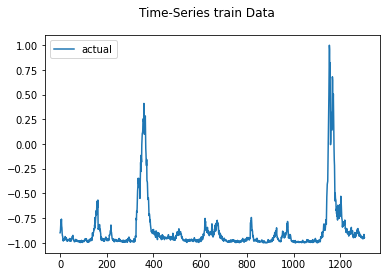

2023-03-06 15:19:27.768049: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-06 15:19:27.768145: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-06 15:19:27.768194: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9f7bdfccc75e): /proc/driver/nvidia/version does not exist
2023-03-06 15:19:27.768734: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 15:19:28.150171: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 55.674
Test RMSE: 69.572
Test sMAPE: 140.954
Test R Squared: -3.455
{'mae': 55.673603445474356, 'rmse': 69.57235769196559, 'smape': 140.9543105467747, 'r2': -3.455124637626521}


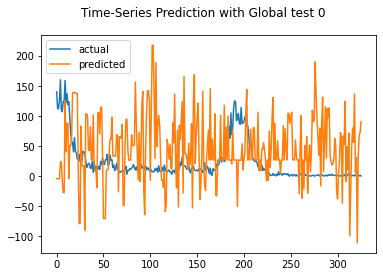

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 59.115
Test RMSE: 71.965
Test sMAPE: 142.273
Test R Squared: -3.767
{'mae': 59.11468530213175, 'rmse': 71.96531107189354, 'smape': 142.27297480674895, 'r2': -3.7668647531734836}


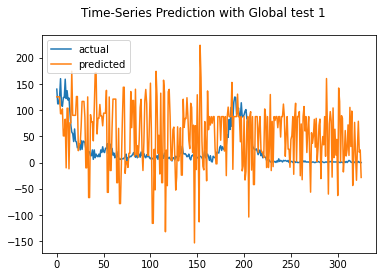

Test MAE: 49.228
Test RMSE: 59.068
Test sMAPE: 142.321
Test R Squared: -2.211
{'mae': 49.22830000181505, 'rmse': 59.06828660882472, 'smape': 142.3210953945965, 'r2': -2.2114056208537294}


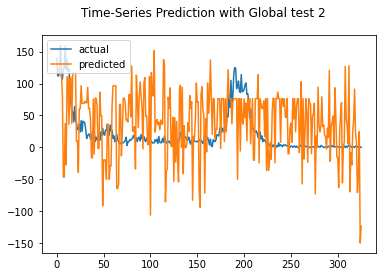

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 50.553
Test RMSE: 62.762
Test sMAPE: 138.782
Test R Squared: -2.626
{'mae': 50.55289314952365, 'rmse': 62.761940937670104, 'smape': 138.78158664787043, 'r2': -2.6255938200433366}


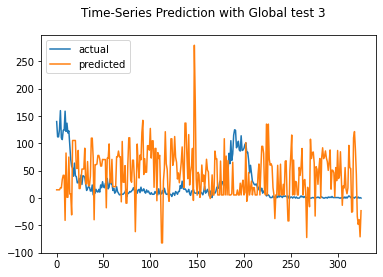

Test MAE: 64.058
Test RMSE: 89.498
Test sMAPE: 132.380
Test R Squared: -6.372
{'mae': 64.05828702303529, 'rmse': 89.49765984537048, 'smape': 132.37960411447875, 'r2': -6.3724150254792145}


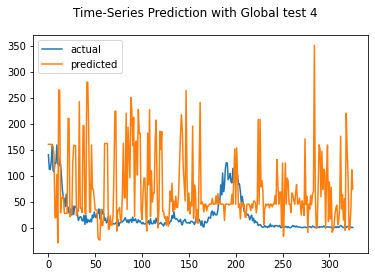

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 46.056
Test RMSE: 56.722
Test sMAPE: 152.457
Test R Squared: -1.961
{'mae': 46.05556530473422, 'rmse': 56.72235063326074, 'smape': 152.45650310886788, 'r2': -1.9613848927522537}


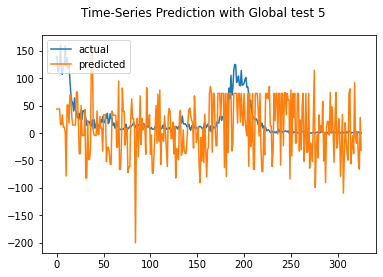

Test MAE: 73.861
Test RMSE: 90.110
Test sMAPE: 155.064
Test R Squared: -6.474
{'mae': 73.86052746494855, 'rmse': 90.11039678014485, 'smape': 155.06424792391365, 'r2': -6.4737096245171335}


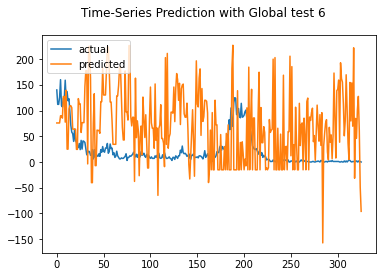

Test MAE: 51.630
Test RMSE: 59.279
Test sMAPE: 147.434
Test R Squared: -2.234
{'mae': 51.62981173670365, 'rmse': 59.27947999961416, 'smape': 147.43380475822644, 'r2': -2.2344108628371866}


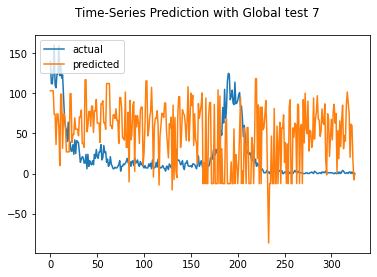

Test MAE: 53.859
Test RMSE: 62.479
Test sMAPE: 133.635
Test R Squared: -2.593
{'mae': 53.85853820783229, 'rmse': 62.479133654573, 'smape': 133.6353064675337, 'r2': -2.5929933553148206}


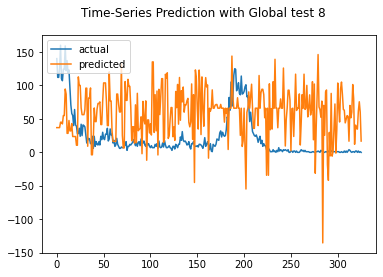

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 56.126
Test RMSE: 62.881
Test sMAPE: 135.976
Test R Squared: -2.639
{'mae': 56.12588107640758, 'rmse': 62.88071388759606, 'smape': 135.97565991407356, 'r2': -2.6393292122097733}


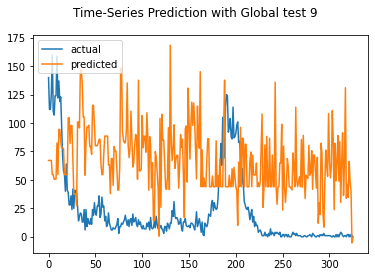

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 59.719
Test RMSE: 68.945
Test sMAPE: 135.661
Test R Squared: -3.375
{'mae': 59.71860235051875, 'rmse': 68.94467062377477, 'smape': 135.66092839884666, 'r2': -3.375098332935984}


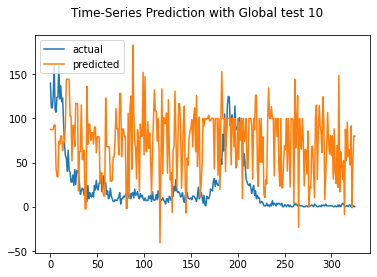

Test MAE: 74.174
Test RMSE: 110.670
Test sMAPE: 143.258
Test R Squared: -10.273
{'mae': 74.17375043034554, 'rmse': 110.6703122412368, 'smape': 143.25823511766498, 'r2': -10.273238280732304}


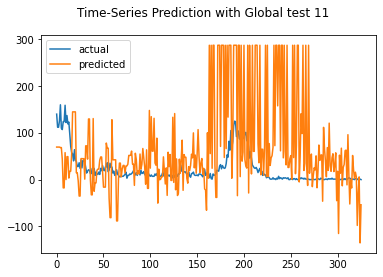

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 52.525
Test RMSE: 66.525
Test sMAPE: 134.222
Test R Squared: -3.073
{'mae': 52.52454346528083, 'rmse': 66.52502679449509, 'smape': 134.22245883192664, 'r2': -3.073395061272694}


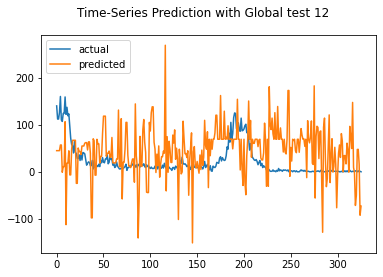

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 39.473
Test RMSE: 51.411
Test sMAPE: 134.082
Test R Squared: -1.433
{'mae': 39.47260563560059, 'rmse': 51.41079267771928, 'smape': 134.08172858459454, 'r2': -1.4327361930000624}


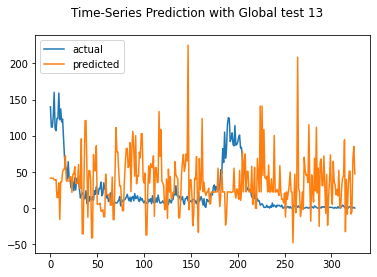

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 43.499
Test RMSE: 51.399
Test sMAPE: 129.725
Test R Squared: -1.432
{'mae': 43.49888413687426, 'rmse': 51.39866003262539, 'smape': 129.72531775118432, 'r2': -1.4315881055828354}


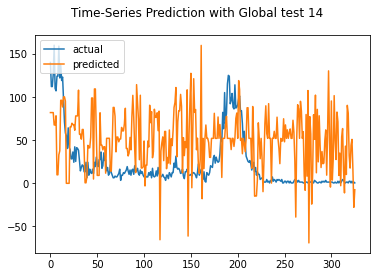

Test MAE: 147.109
Test RMSE: 178.713
Test sMAPE: 160.924
Test R Squared: -28.397
{'mae': 147.1089807242338, 'rmse': 178.7129201110842, 'smape': 160.92424013971652, 'r2': -28.39668227183623}


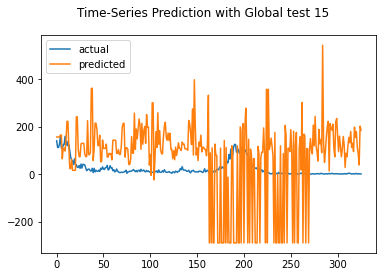

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 55.466
Test RMSE: 64.318
Test sMAPE: 133.879
Test R Squared: -2.808
{'mae': 55.4662400846101, 'rmse': 64.31799871102689, 'smape': 133.8791980932721, 'r2': -2.8076012568458224}


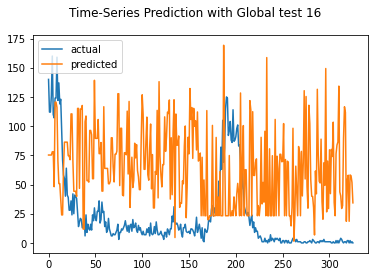

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 50.623
Test RMSE: 62.213
Test sMAPE: 139.091
Test R Squared: -2.562
{'mae': 50.62264148717278, 'rmse': 62.21343543397009, 'smape': 139.09142376871452, 'r2': -2.5624992683084535}


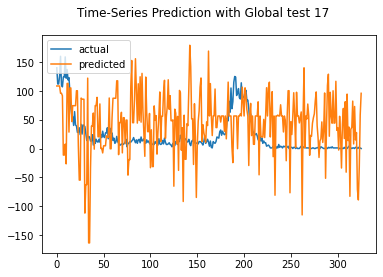

Test MAE: 49.700
Test RMSE: 60.899
Test sMAPE: 128.001
Test R Squared: -2.414
{'mae': 49.700207296324656, 'rmse': 60.89912149051674, 'smape': 128.00126419883773, 'r2': -2.4135673159296136}


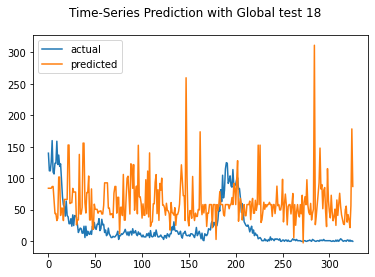

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 53.443
Test RMSE: 67.289
Test sMAPE: 141.898
Test R Squared: -3.168
{'mae': 53.443287600128926, 'rmse': 67.28940155964614, 'smape': 141.89752093779435, 'r2': -3.167539723218195}


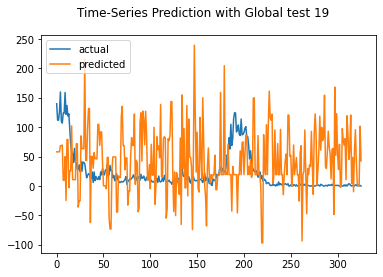

Test MAE: 66.796
Test RMSE: 80.767
Test sMAPE: 140.111
Test R Squared: -5.004
{'mae': 66.79631705079342, 'rmse': 80.7671724399214, 'smape': 140.11145204320053, 'r2': -5.004214158395181}


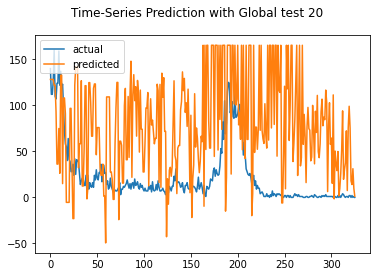

Test MAE: 97.639
Test RMSE: 127.747
Test sMAPE: 156.647
Test R Squared: -14.021
{'mae': 97.63861229192992, 'rmse': 127.74691699964373, 'smape': 156.64691726841085, 'r2': -14.020599684629468}


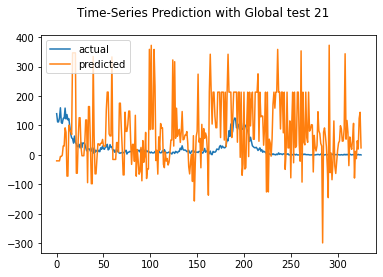

Test MAE: 93.857
Test RMSE: 105.811
Test sMAPE: 155.371
Test R Squared: -9.305
{'mae': 93.8566570581834, 'rmse': 105.81113064601534, 'smape': 155.3706379107973, 'r2': -9.305026818501783}


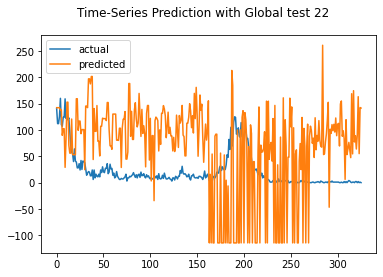

Test MAE: 87.032
Test RMSE: 102.313
Test sMAPE: 152.424
Test R Squared: -8.635
{'mae': 87.03184102503069, 'rmse': 102.31301270899384, 'smape': 152.42395796838352, 'r2': -8.634921095723932}


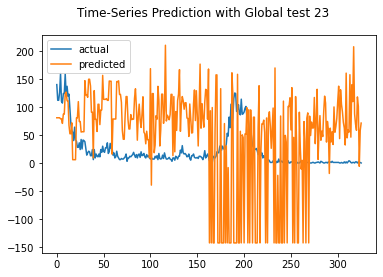

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 48.186
Test RMSE: 56.334
Test sMAPE: 130.560
Test R Squared: -1.921
{'mae': 48.18619387884813, 'rmse': 56.33365728139969, 'smape': 130.56039343796132, 'r2': -1.9209378126630319}


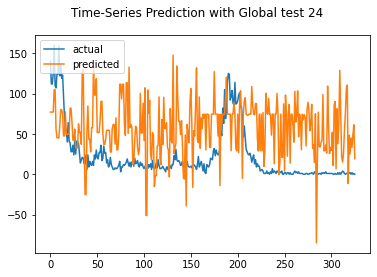

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 50.033
Test RMSE: 62.156
Test sMAPE: 137.917
Test R Squared: -2.556
{'mae': 50.0334717002383, 'rmse': 62.15563293720182, 'smape': 137.9168449902189, 'r2': -2.555882508110164}


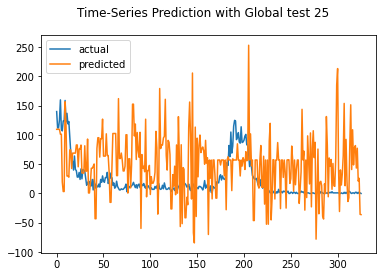

Test MAE: 46.835
Test RMSE: 60.605
Test sMAPE: 155.718
Test R Squared: -2.381
{'mae': 46.835329163019644, 'rmse': 60.605489016375365, 'smape': 155.71791952422507, 'r2': -2.380728819926031}


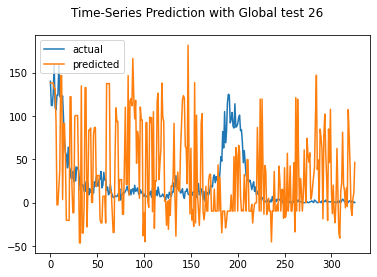

Test MAE: 61.840
Test RMSE: 72.571
Test sMAPE: 134.886
Test R Squared: -3.847
{'mae': 61.840170652588455, 'rmse': 72.57080632196325, 'smape': 134.88588492563093, 'r2': -3.847416236291976}


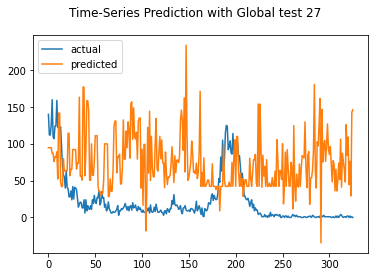

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 46.996
Test RMSE: 57.547
Test sMAPE: 132.879
Test R Squared: -2.048
{'mae': 46.99579120541643, 'rmse': 57.54686547938038, 'smape': 132.87909244373895, 'r2': -2.048103869408368}


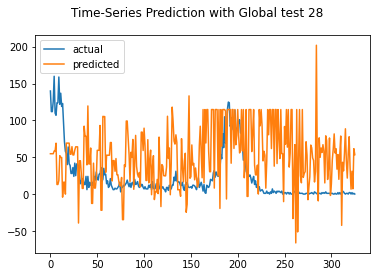

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 54.012
Test RMSE: 63.315
Test sMAPE: 132.647
Test R Squared: -2.690
{'mae': 54.01231066955745, 'rmse': 63.31481837649792, 'smape': 132.64685246481852, 'r2': -2.6897517468112127}


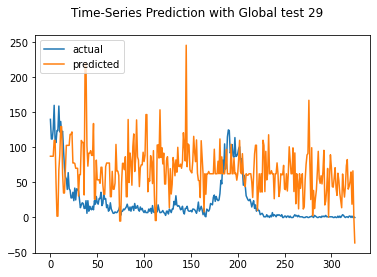

Test MAE: 51.649
Test RMSE: 64.098
Test sMAPE: 125.288
Test R Squared: -2.782
{'mae': 51.64943062491212, 'rmse': 64.09764710954815, 'smape': 125.28754048634617, 'r2': -2.7815564843788074}


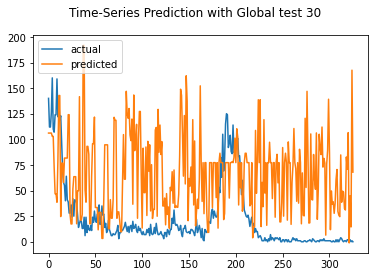

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 52.145
Test RMSE: 61.412
Test sMAPE: 135.248
Test R Squared: -2.471
{'mae': 52.14539386295468, 'rmse': 61.41156497843237, 'smape': 135.24754072618055, 'r2': -2.471256819050328}


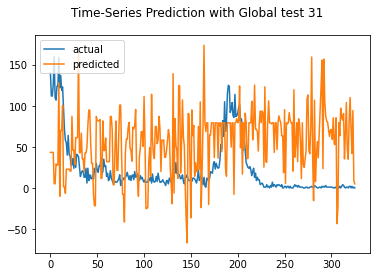

Test MAE: 56.525
Test RMSE: 75.369
Test sMAPE: 159.491
Test R Squared: -4.229
{'mae': 56.52519438648882, 'rmse': 75.36946936339282, 'smape': 159.49067590038223, 'r2': -4.22850263833203}


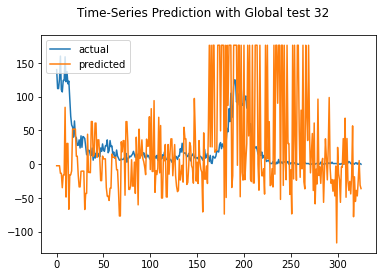

Test MAE: 112.933
Test RMSE: 128.608
Test sMAPE: 159.055
Test R Squared: -14.224
{'mae': 112.93343850293773, 'rmse': 128.60828039523184, 'smape': 159.0552257641344, 'r2': -14.223842384359974}


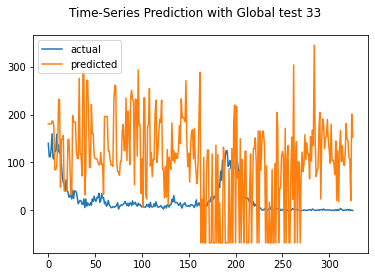

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 47.574
Test RMSE: 57.885
Test sMAPE: 141.579
Test R Squared: -2.084
{'mae': 47.57367348433272, 'rmse': 57.88489689252908, 'smape': 141.5788273384183, 'r2': -2.08401828497506}


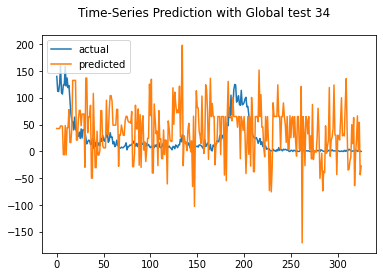

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 39.282
Test RMSE: 51.913
Test sMAPE: 150.390
Test R Squared: -1.480
{'mae': 39.28224355795998, 'rmse': 51.91284320407517, 'smape': 150.3896771916657, 'r2': -1.4804818114585738}


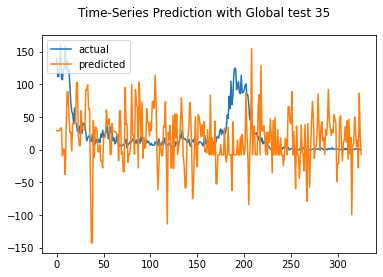

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 45.105
Test RMSE: 56.374
Test sMAPE: 134.897
Test R Squared: -1.925
{'mae': 45.10496390743489, 'rmse': 56.37370843115333, 'smape': 134.89735635350095, 'r2': -1.9250926469163936}


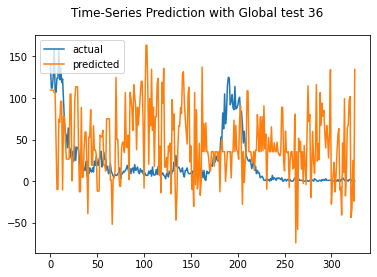

Test MAE: 57.911
Test RMSE: 65.033
Test sMAPE: 136.090
Test R Squared: -2.893
{'mae': 57.91097282485728, 'rmse': 65.03254987406417, 'smape': 136.09045379909372, 'r2': -2.8926735268965476}


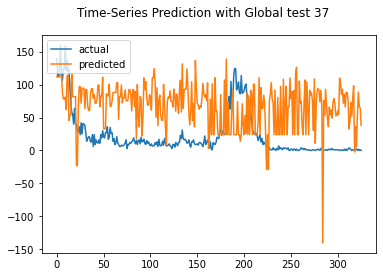

Test MAE: 87.766
Test RMSE: 119.837
Test sMAPE: 149.971
Test R Squared: -12.218
{'mae': 87.76567193719507, 'rmse': 119.8367465242292, 'smape': 149.97142321568595, 'r2': -12.218020945331652}


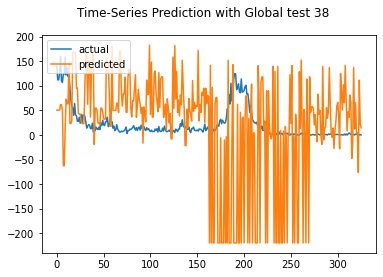

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 56.591
Test RMSE: 72.278
Test sMAPE: 141.035
Test R Squared: -3.808
{'mae': 56.591476291966586, 'rmse': 72.2776843531895, 'smape': 141.03451956464878, 'r2': -3.8083367578114}


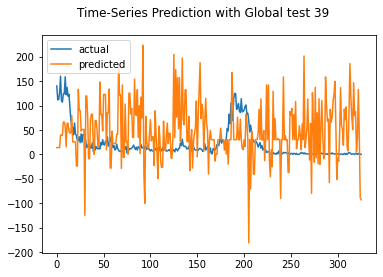

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Test MAE: 59.778
Test RMSE: 77.892
Test sMAPE: 150.978
Test R Squared: -4.584
{'mae': 59.77811079138627, 'rmse': 77.8917168881179, 'smape': 150.9778023456937, 'r2': -4.58430293299243}


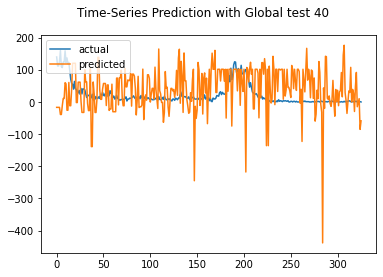

Test MAE: 69.693
Test RMSE: 84.827
Test sMAPE: 153.212
Test R Squared: -5.623
{'mae': 69.69343959352722, 'rmse': 84.82707914297418, 'smape': 153.21210984634618, 'r2': -5.623010484354913}


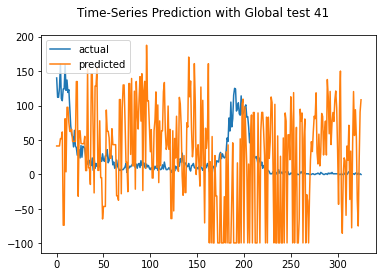

Test MAE: 92.808
Test RMSE: 135.372
Test sMAPE: 144.320
Test R Squared: -15.867
{'mae': 92.80777243410517, 'rmse': 135.37151006231244, 'smape': 144.3197495902199, 'r2': -15.867121105282212}


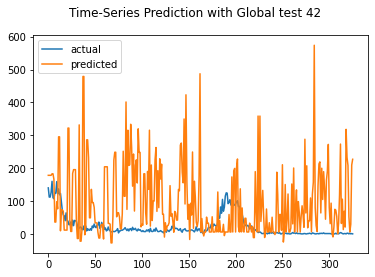

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 45.386
Test RMSE: 53.328
Test sMAPE: 129.791
Test R Squared: -1.618
{'mae': 45.3864491492327, 'rmse': 53.328452665853476, 'smape': 129.7913597302573, 'r2': -1.6176066281504378}


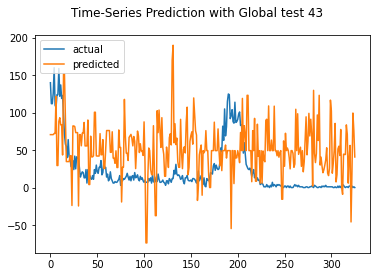

Test MAE: 62.464
Test RMSE: 79.972
Test sMAPE: 137.357
Test R Squared: -4.887
{'mae': 62.463680387640295, 'rmse': 79.97238632956488, 'smape': 137.35729398642607, 'r2': -4.886627118724454}


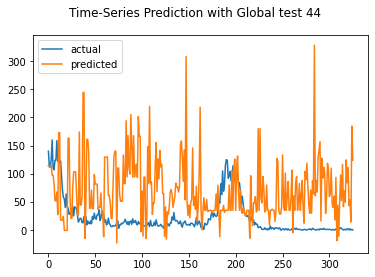

Test MAE: 67.870
Test RMSE: 76.827
Test sMAPE: 141.124
Test R Squared: -4.433
{'mae': 67.86956108823145, 'rmse': 76.82685084627668, 'smape': 141.12392290529212, 'r2': -4.432659422237581}


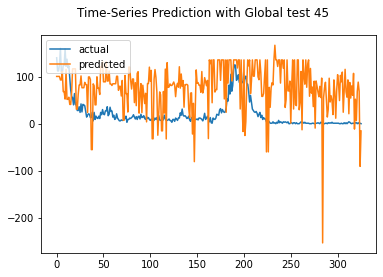

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 50.605
Test RMSE: 58.884
Test sMAPE: 131.700
Test R Squared: -2.191
{'mae': 50.605322745222985, 'rmse': 58.88375942902826, 'smape': 131.6998567092899, 'r2': -2.191372332636813}


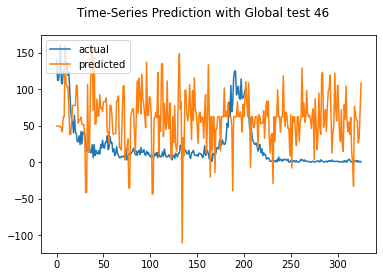

Test MAE: 101.514
Test RMSE: 123.946
Test sMAPE: 153.854
Test R Squared: -13.140
{'mae': 101.5135340605594, 'rmse': 123.94600993074215, 'smape': 153.85406595345063, 'r2': -13.140068627053108}


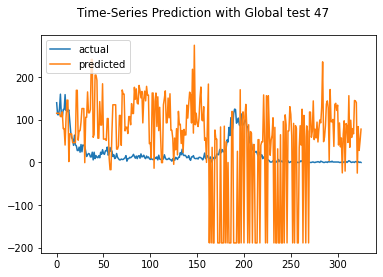

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 44.658
Test RMSE: 51.887
Test sMAPE: 132.164
Test R Squared: -1.478
{'mae': 44.65758993362356, 'rmse': 51.88655619636494, 'smape': 132.16380458100642, 'r2': -1.4779703737582213}


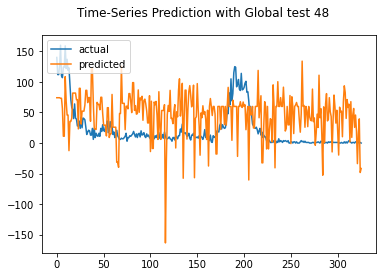

Test MAE: 47.532
Test RMSE: 62.197
Test sMAPE: 149.005
Test R Squared: -2.561
{'mae': 47.5322567921109, 'rmse': 62.19667027666373, 'smape': 149.00531959526134, 'r2': -2.560579496065843}


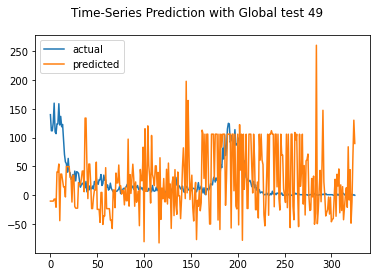

Test MAE: 68.004
Test RMSE: 83.254
Test sMAPE: 137.551
Test R Squared: -5.380
{'mae': 68.00436554492617, 'rmse': 83.25388767962508, 'smape': 137.55140879434575, 'r2': -5.3796295607602245}


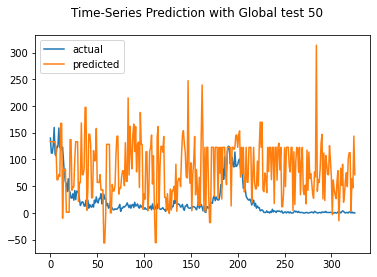

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 51.056
Test RMSE: 59.411
Test sMAPE: 141.277
Test R Squared: -2.249
{'mae': 51.055768009526595, 'rmse': 59.41062933960546, 'smape': 141.27718763747666, 'r2': -2.2487382519358072}


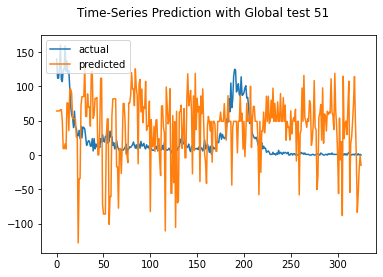

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 43.131
Test RMSE: 56.015
Test sMAPE: 134.341
Test R Squared: -1.888
{'mae': 43.13093812498578, 'rmse': 56.015293433198956, 'smape': 134.34112013818145, 'r2': -1.8880163454310104}


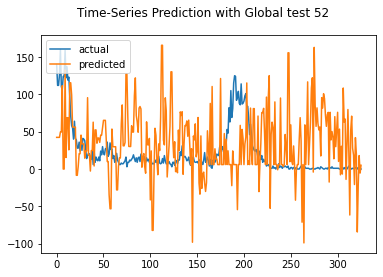

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 47.766
Test RMSE: 60.511
Test sMAPE: 135.741
Test R Squared: -2.370
{'mae': 47.76640933560082, 'rmse': 60.510613909688715, 'smape': 135.74136508288404, 'r2': -2.3701523538229137}


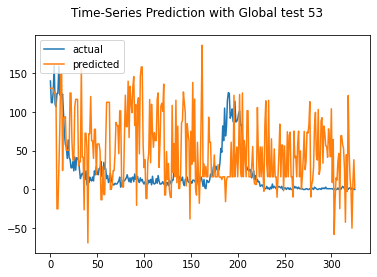

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 36.948
Test RMSE: 44.928
Test sMAPE: 128.599
Test R Squared: -0.858
{'mae': 36.9478738801611, 'rmse': 44.92776452707959, 'smape': 128.59931373359987, 'r2': -0.8578730546251749}


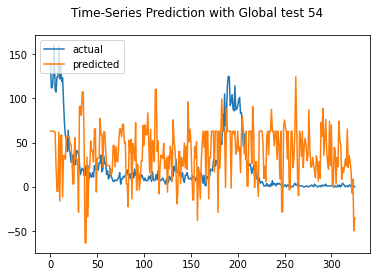

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 45.063
Test RMSE: 55.453
Test sMAPE: 128.960
Test R Squared: -1.830
{'mae': 45.062964352361995, 'rmse': 55.45282459734998, 'smape': 128.95965164658955, 'r2': -1.8303084083074839}


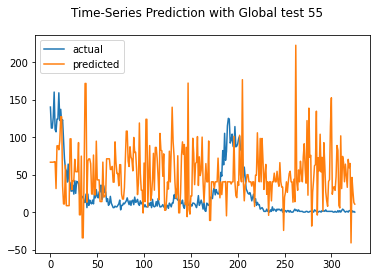

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 40.746
Test RMSE: 49.633
Test sMAPE: 125.740
Test R Squared: -1.267
{'mae': 40.74569306819717, 'rmse': 49.632764149450544, 'smape': 125.73999923184934, 'r2': -1.2673749354070054}


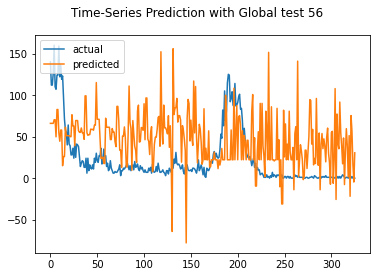

Test MAE: 62.749
Test RMSE: 74.903
Test sMAPE: 137.166
Test R Squared: -4.164
{'mae': 62.749087876885945, 'rmse': 74.90333888835806, 'smape': 137.16556120550715, 'r2': -4.164030167232969}


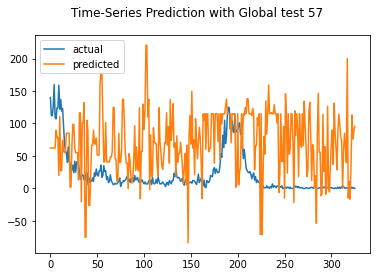

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 51.951
Test RMSE: 62.393
Test sMAPE: 131.849
Test R Squared: -2.583
{'mae': 51.95079794416398, 'rmse': 62.39322373420342, 'smape': 131.8489676782719, 'r2': -2.5831192889174193}


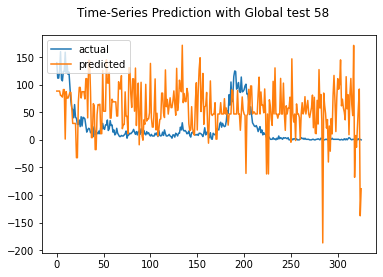

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 54.159
Test RMSE: 67.940
Test sMAPE: 145.678
Test R Squared: -3.249
{'mae': 54.15878415363698, 'rmse': 67.94028046024502, 'smape': 145.67770079901314, 'r2': -3.2485534547383343}


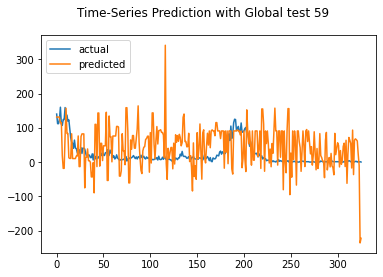

Test MAE: 164.912
Test RMSE: 188.389
Test sMAPE: 168.085
Test R Squared: -31.666
{'mae': 164.91181854382614, 'rmse': 188.38947029442468, 'smape': 168.08497996706964, 'r2': -31.666278938154996}


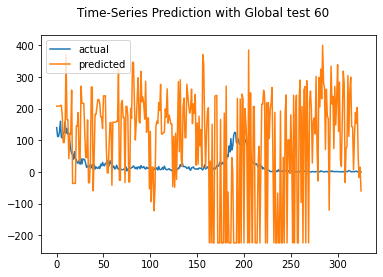

Test MAE: 60.498
Test RMSE: 73.508
Test sMAPE: 138.470
Test R Squared: -3.973
{'mae': 60.49812154225045, 'rmse': 73.50775543261393, 'smape': 138.4702018302417, 'r2': -3.973392552271564}


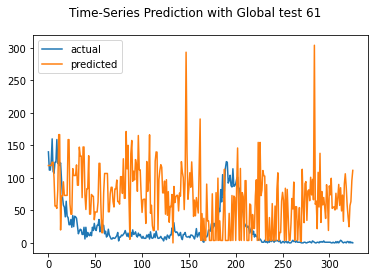

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 41.132
Test RMSE: 53.472
Test sMAPE: 138.547
Test R Squared: -1.632
{'mae': 41.13196274939856, 'rmse': 53.47209970089454, 'smape': 138.54716585775955, 'r2': -1.6317273396937848}


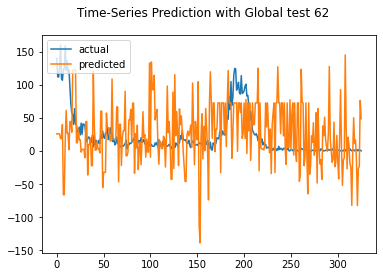

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 54.619
Test RMSE: 69.702
Test sMAPE: 137.780
Test R Squared: -3.472
{'mae': 54.61875777632181, 'rmse': 69.70222795965896, 'smape': 137.7798422220338, 'r2': -3.4717728660882488}


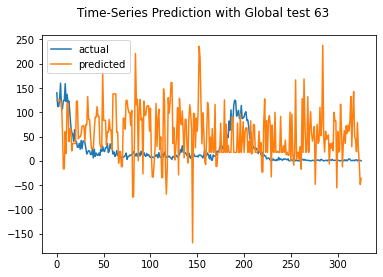

Test MAE: 57.505
Test RMSE: 67.629
Test sMAPE: 132.235
Test R Squared: -3.210
{'mae': 57.50510211883147, 'rmse': 67.6289001120843, 'smape': 132.23535932577926, 'r2': -3.20969919964661}


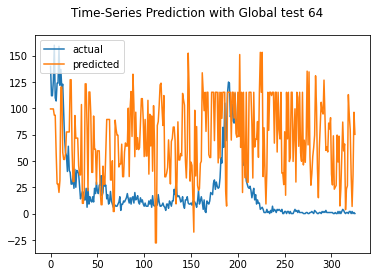

Test MAE: 66.139
Test RMSE: 83.048
Test sMAPE: 139.667
Test R Squared: -5.348
{'mae': 66.13859413600773, 'rmse': 83.04774170127745, 'smape': 139.66744767360382, 'r2': -5.348075316197322}


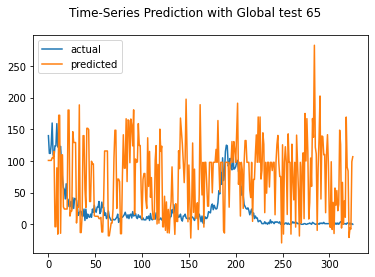

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 50.948
Test RMSE: 61.035
Test sMAPE: 134.055
Test R Squared: -2.429
{'mae': 50.94789306737162, 'rmse': 61.034712668224905, 'smape': 134.05519566491154, 'r2': -2.4287847727933984}


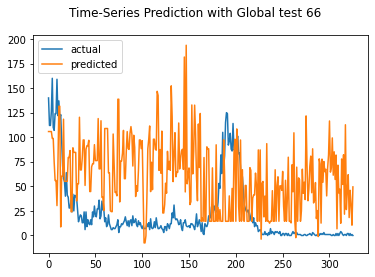

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 55.500
Test RMSE: 68.980
Test sMAPE: 136.126
Test R Squared: -3.380
{'mae': 55.49950296308365, 'rmse': 68.97994922160025, 'smape': 136.1263367165848, 'r2': -3.3795769045925503}


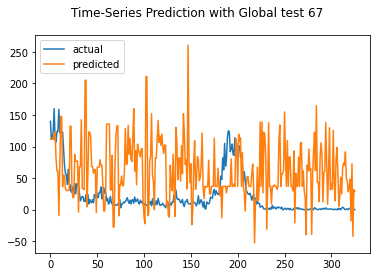

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 49.858
Test RMSE: 60.485
Test sMAPE: 137.370
Test R Squared: -2.367
{'mae': 49.858197096301005, 'rmse': 60.48534599975573, 'smape': 137.37013149747264, 'r2': -2.3673383375422596}


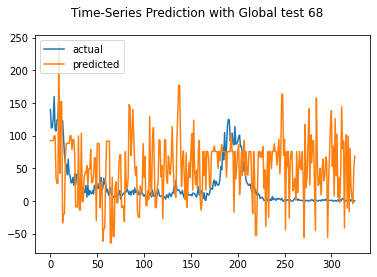

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 54.985
Test RMSE: 66.498
Test sMAPE: 143.854
Test R Squared: -3.070
{'mae': 54.98478436305479, 'rmse': 66.49787679762217, 'smape': 143.8536682515437, 'r2': -3.0700708958832603}


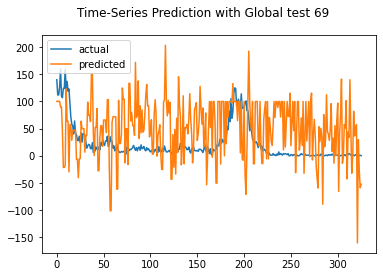

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 52.699
Test RMSE: 65.324
Test sMAPE: 146.907
Test R Squared: -2.928
{'mae': 52.69887367786805, 'rmse': 65.32390034432981, 'smape': 146.9068165450738, 'r2': -2.9276305679979804}


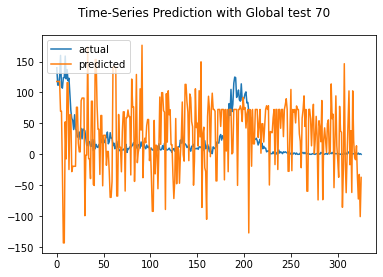

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Test MAE: 55.795
Test RMSE: 68.182
Test sMAPE: 135.406
Test R Squared: -3.279
{'mae': 55.79492024099169, 'rmse': 68.18208409067157, 'smape': 135.40643162185637, 'r2': -3.278848996122254}


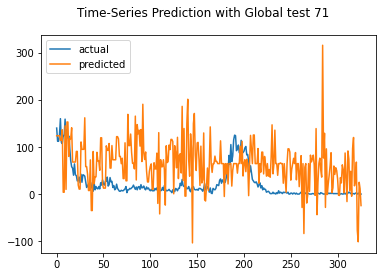

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Test MAE: 54.852
Test RMSE: 64.996
Test sMAPE: 142.583
Test R Squared: -2.888
{'mae': 54.85193894593262, 'rmse': 64.99608474296258, 'smape': 142.58308507097016, 'r2': -2.8883093414397942}


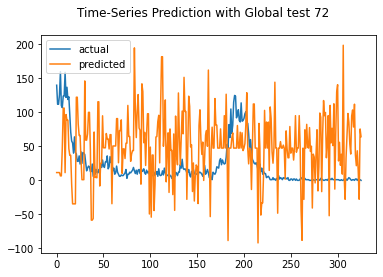

Test MAE: 56.627
Test RMSE: 66.501
Test sMAPE: 134.667
Test R Squared: -3.070
{'mae': 56.62748175384077, 'rmse': 66.50135827372014, 'smape': 134.66749516138324, 'r2': -3.070497081685054}


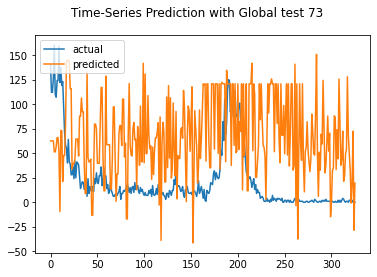

Test MAE: 88.964
Test RMSE: 108.694
Test sMAPE: 153.755
Test R Squared: -9.874
{'mae': 88.96362052739032, 'rmse': 108.69433171567123, 'smape': 153.7545981199249, 'r2': -9.874272444920049}


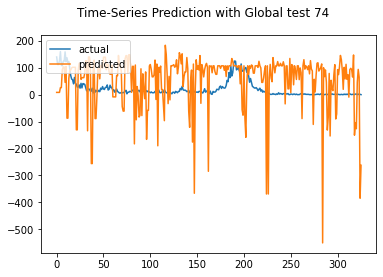

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 50.861
Test RMSE: 64.866
Test sMAPE: 126.633
Test R Squared: -2.873
{'mae': 50.86078695614645, 'rmse': 64.86635717815479, 'smape': 126.63284138386723, 'r2': -2.872803253344007}


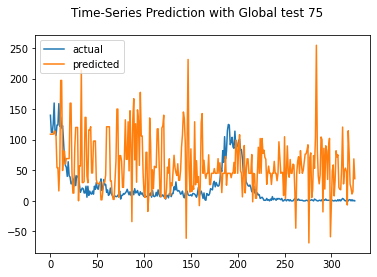

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 52.581
Test RMSE: 64.465
Test sMAPE: 139.731
Test R Squared: -2.825
{'mae': 52.581460787657576, 'rmse': 64.46496250110604, 'smape': 139.73056279416576, 'r2': -2.8250215382692025}


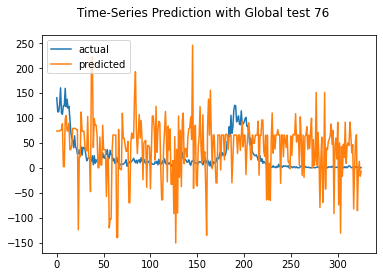

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 46.717
Test RMSE: 54.236
Test sMAPE: 129.137
Test R Squared: -1.707
{'mae': 46.717422386619944, 'rmse': 54.23590804628373, 'smape': 129.13694416533275, 'r2': -1.7074487699157457}


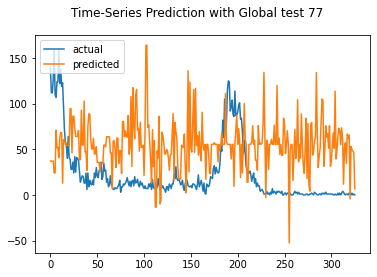

Test MAE: 54.789
Test RMSE: 69.767
Test sMAPE: 135.180
Test R Squared: -3.480
{'mae': 54.78922659908336, 'rmse': 69.76691626725362, 'smape': 135.18046324643169, 'r2': -3.480076923467567}


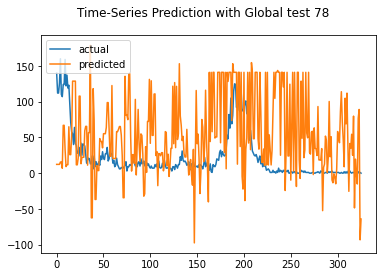

Test MAE: 65.748
Test RMSE: 84.481
Test sMAPE: 146.522
Test R Squared: -5.569
{'mae': 65.74798427769012, 'rmse': 84.48089125429759, 'smape': 146.52220707863808, 'r2': -5.5690624419900105}


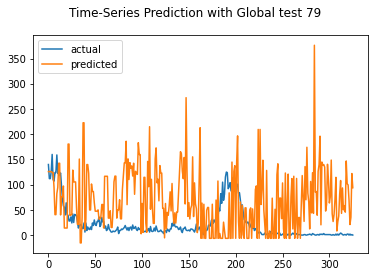

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 46.642
Test RMSE: 57.810
Test sMAPE: 136.922
Test R Squared: -2.076
{'mae': 46.64166624908067, 'rmse': 57.81007031613551, 'smape': 136.9223705931954, 'r2': -2.076050148598039}


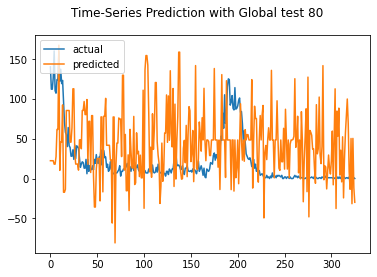

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 52.756
Test RMSE: 59.228
Test sMAPE: 133.198
Test R Squared: -2.229
{'mae': 52.756046452405265, 'rmse': 59.22767135613777, 'smape': 133.1981138595029, 'r2': -2.2287597601871414}


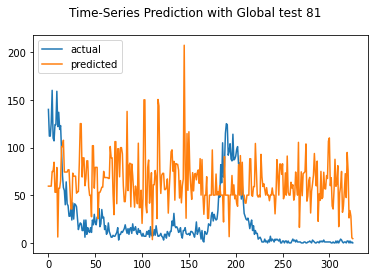

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 44.149
Test RMSE: 56.600
Test sMAPE: 138.131
Test R Squared: -1.949
{'mae': 44.14923570739345, 'rmse': 56.60044902083073, 'smape': 138.13074452077612, 'r2': -1.9486699865219013}


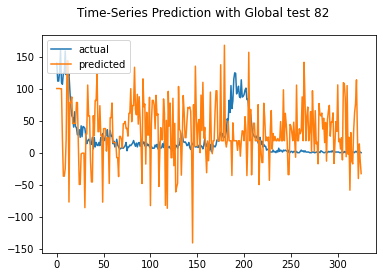

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 57.693
Test RMSE: 66.064
Test sMAPE: 135.217
Test R Squared: -3.017
{'mae': 57.693235244487695, 'rmse': 66.06404291845301, 'smape': 135.21689523068795, 'r2': -3.017137633029866}


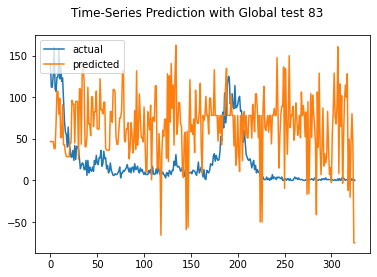

Test MAE: 74.301
Test RMSE: 85.858
Test sMAPE: 162.866
Test R Squared: -5.785
{'mae': 74.30099375609971, 'rmse': 85.85793064220242, 'smape': 162.86556339174513, 'r2': -5.784959347795493}


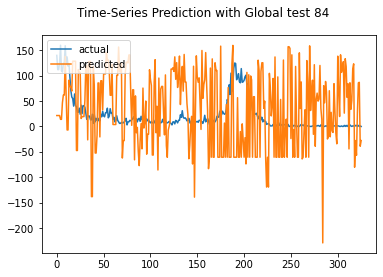

Test MAE: 61.133
Test RMSE: 71.292
Test sMAPE: 147.991
Test R Squared: -3.678
{'mae': 61.13307500434068, 'rmse': 71.29222379375094, 'smape': 147.99088217190618, 'r2': -3.6781133410119136}


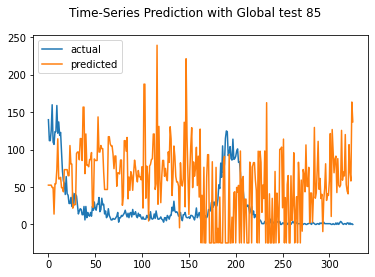

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 65.361
Test RMSE: 81.267
Test sMAPE: 145.613
Test R Squared: -5.079
{'mae': 65.36137609778007, 'rmse': 81.26656035817746, 'smape': 145.6133522222497, 'r2': -5.078692480574469}


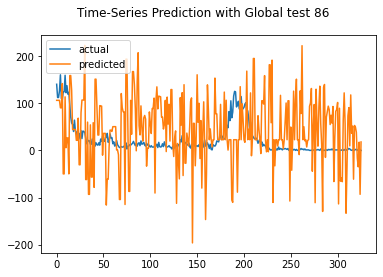

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 48.989
Test RMSE: 56.563
Test sMAPE: 129.294
Test R Squared: -1.945
{'mae': 48.98913350207674, 'rmse': 56.56283008296468, 'smape': 129.29389331960724, 'r2': -1.94475167943986}


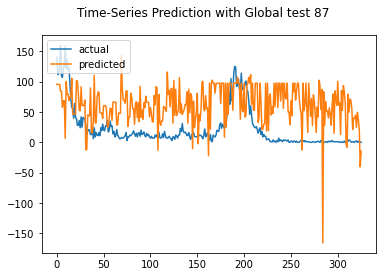

Test MAE: 56.265
Test RMSE: 75.229
Test sMAPE: 130.685
Test R Squared: -4.209
{'mae': 56.26472400137983, 'rmse': 75.22908510260304, 'smape': 130.68515732669118, 'r2': -4.209043408882593}


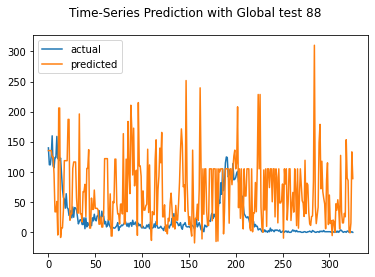

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 55.631
Test RMSE: 71.653
Test sMAPE: 163.313
Test R Squared: -3.726
{'mae': 55.63123163160371, 'rmse': 71.65305786012323, 'smape': 163.31299610826503, 'r2': -3.725588209844614}


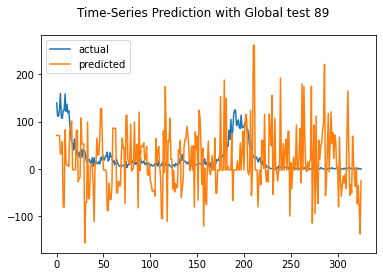

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 50.779
Test RMSE: 58.924
Test sMAPE: 131.715
Test R Squared: -2.196
{'mae': 50.77910125219017, 'rmse': 58.92443608666123, 'smape': 131.71523844653302, 'r2': -2.195783029189641}


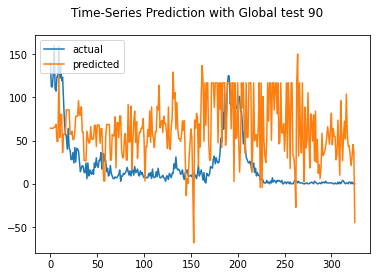

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 55.158
Test RMSE: 69.682
Test sMAPE: 137.397
Test R Squared: -3.469
{'mae': 55.15778238202896, 'rmse': 69.68159001744947, 'smape': 137.39681236174144, 'r2': -3.469125188101293}


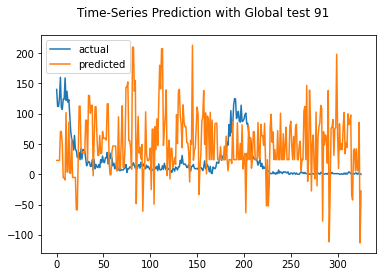

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 51.882
Test RMSE: 66.071
Test sMAPE: 149.128
Test R Squared: -3.018
{'mae': 51.882499623883724, 'rmse': 66.07056426865671, 'smape': 149.12768851486672, 'r2': -3.017930755980214}


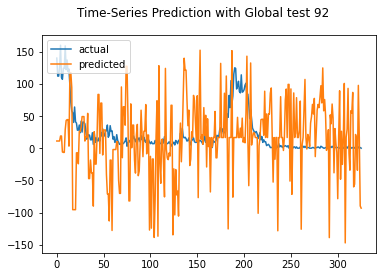

Test MAE: 67.224
Test RMSE: 81.355
Test sMAPE: 137.105
Test R Squared: -5.092
{'mae': 67.22386909353952, 'rmse': 81.35548843417045, 'smape': 137.10478273460294, 'r2': -5.092003298431117}


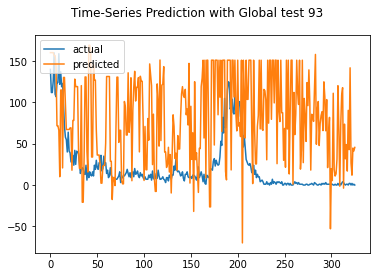

Test MAE: 64.638
Test RMSE: 87.921
Test sMAPE: 155.939
Test R Squared: -6.115
{'mae': 64.6376434627669, 'rmse': 87.92146213398217, 'smape': 155.93852745781723, 'r2': -6.115021549746342}


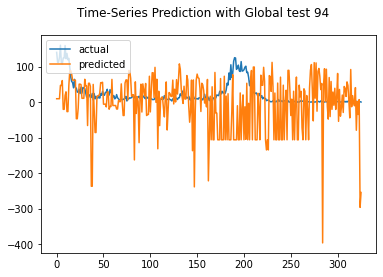

Test MAE: 64.079
Test RMSE: 73.325
Test sMAPE: 149.622
Test R Squared: -3.949
{'mae': 64.0790716358489, 'rmse': 73.3248368124475, 'smape': 149.62230474970255, 'r2': -3.948671508763918}


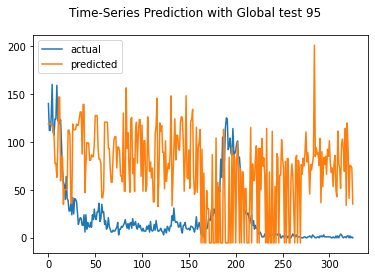

Test MAE: 162.384
Test RMSE: 216.487
Test sMAPE: 157.427
Test R Squared: -42.137
{'mae': 162.3837666528905, 'rmse': 216.48721308295535, 'smape': 157.427477328064, 'r2': -42.13709704900141}


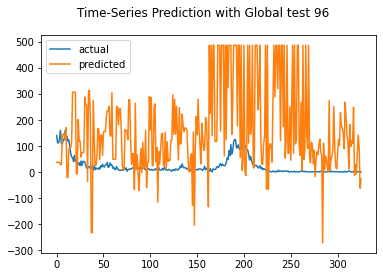

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 46.294
Test RMSE: 53.773
Test sMAPE: 128.743
Test R Squared: -1.661
{'mae': 46.293597517569374, 'rmse': 53.773245666827926, 'smape': 128.74306575519427, 'r2': -1.6614537123713058}


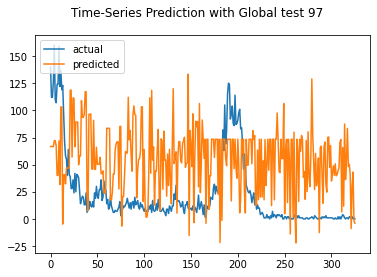

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 49.708
Test RMSE: 61.347
Test sMAPE: 150.499
Test R Squared: -2.464
{'mae': 49.70826769953857, 'rmse': 61.34683798547833, 'smape': 150.49866683157094, 'r2': -2.4639433559028556}


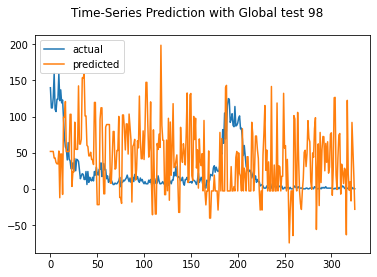

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 47.791
Test RMSE: 60.819
Test sMAPE: 132.055
Test R Squared: -2.405
{'mae': 47.790961888853026, 'rmse': 60.81916536859771, 'smape': 132.05508244522224, 'r2': -2.4046096684133214}


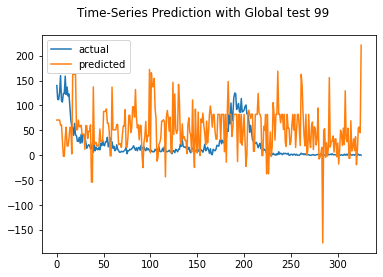

rmse : average=74.438, std=27.821
mae : average=60.491, std=22.032
smape : average=140.842, std=9.640
r2 : average=-4.812, std=5.985


([74.43790112218164, 27.820840454953466],
 [60.49063118631856, 22.031858066172198],
 [140.84199553578625, 9.64000889269047],
 [-4.812457506006789, 5.985311467436038])

In [13]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=False, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')
